# Two Stages and Two Stacks

Let's train two L=2 VPUs then have a look at training a next stage.

So far we've been training in stack formations (stack first). Here we look to train all the stage 0s first, then the stage 1s, etc. - i.e. a stage-first training.

In [1]:
import numpy as np
from src.tests.test_vpu import rand_same, rand_diff, rand_opposite
from src.var_processor.vpu import BinaryVPU
from src.tests.wrapper_vpu import VPUWrapper
from src.var_processor.stage import Stage
from src.tests.wrapper_stage import StageWrapper

Train the stage 0 VPUs for two stacks first. This should give [1, 1] and [-1, 1] style eigenvectors. For fun let's also through in some random data

In [8]:
size = 2
stage_num = 2
stages_0 = [StageWrapper(size, size) for i in range(stage_num)]

for _ in range(0, 1000):
    data = rand_opposite(size=size, negative=True)
    for stage in stages_0:
        causes, pred_inputs, clamped_residuals = stage.iterate(data)
        data = clamped_residuals.copy()
        
for wrapper in stages_0:
    print(wrapper.stage.get_eigenvectors(), "\n----\n")

[array([[89],
       [90]], dtype=int8)] 
----

[array([[-90],
       [ 89]], dtype=int8)] 
----



Then let's define two stages at level 1 with double the input size.

In [14]:
stages_1 = [StageWrapper(size*2, size) for i in range(stage_num)]

Now let's train the stages at level 1 but without training the lower stages. Stage 1 of stack 0 is trained by just supplying the input, but stage 1 of stack 1 needs the residual.

Let's first try in a closed loop mode, where the r is looped around.

In [15]:
[wrapper.stage for wrapper in stages_1]

[Stage:Input length: 4Vector length: 2, Stage:Input length: 4Vector length: 2]

In [17]:
for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    for stage in stages_1:
        causes, pred_inputs, clamped_residuals = stage.iterate(data)
        data = clamped_residuals.copy()
        
for wrapper in stages_1:
    print(wrapper.stage.get_eigenvectors(), "\n----\n")

[array([[90],
       [89]], dtype=int8), array([[-89],
       [-90]], dtype=int8)] 
----

[array([[-89],
       [ 89]], dtype=int8), array([[-90],
       [ 89]], dtype=int8)] 
----



So orthogonal eigenvectors are learned fairly quickly. Not different VPUs in the stage can have different eigenvectors, e.g. flipped sign.

Now what happens when we do the training via a stack, i.e. we only pass signals down each stack separately and use the top level residual.

In [25]:
from src.var_processor.stack import Stack
from src.tests.wrapper_stack import StackWrapper

# Define 2 stacks with an original input of 4
wrappers = [StackWrapper(2, 4) for i in range(0, 2)]

In [26]:
wrappers[0].stack.stages

[Stage:Input length: 4Vector length: 2, Stage:Input length: 2Vector length: 2]

<IPython.core.display.Javascript object>


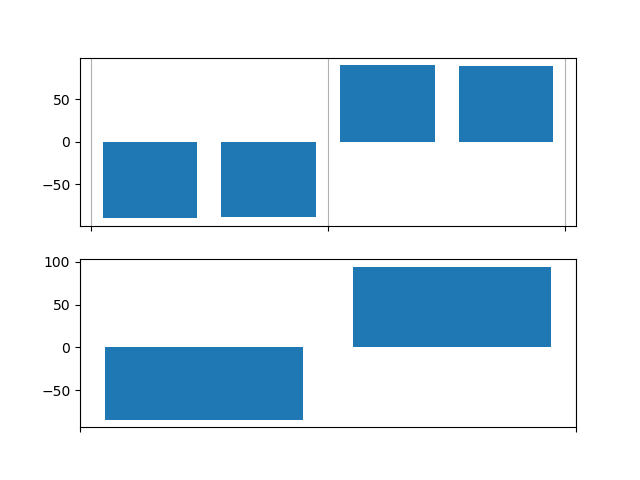

<IPython.core.display.Javascript object>


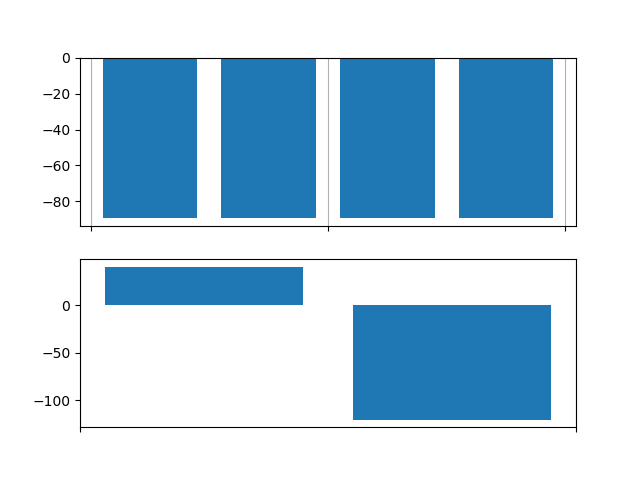

In [31]:
%matplotlib notebook
# Let's just have a look at training as two separate stacks
for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    for stack in wrappers:
        causes, pred_inputs, clamped_residuals = stack.iterate(data)
        data = clamped_residuals.copy()
        
for wrapper in wrappers:
    wrapper.plot_eigenvectors()

Ah yes - if we train this way, our eigenvectors are not orthogonal. The stage 1 eigenvectors are [-1, -1] and [1. 1] / [1, 1], [-1, -1] and our stage 0 eigenvectors are [118, -31] and [106, 66].

So now let's try to train the two stages in closed loop mode. We need to treat each stage independently.

```
 if np.random.uniform() > 0.95:
        # Generate random data
        data = np.random.randint(low=-1, high=2, size=(size,1))
    else:
        # Generate as opposites
        data = rand_opposite(size=size, negative=True)
```

Training the upper stage in a closed loop manner is okay - we just feed back the causes for the stage, compute the predictions and the residuals and then pass to the next stack.

For the lower stages things get a bit more tricky. We have the input for (lower) stage 0 of stack 0 - this is just the output of (upper) stage 1 of stack 0. We then get the output for stage 0 of stack 0, compute the residual and pass to stage 0 of stack 1. We then combine both stage 0 predictions before feeding it back to stage 1 of stack 0. The prediction from stage 1 of stack 0 if then passed to stack 1, and we do the same in reverse.

Stage:Input length: 4Vector length: 2


<IPython.core.display.Javascript object>


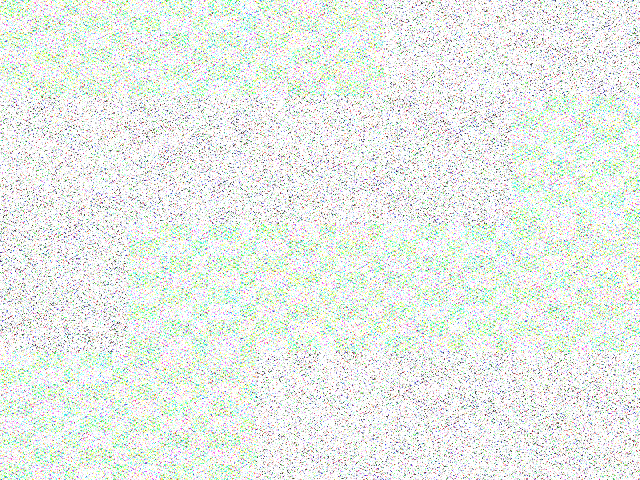

<IPython.core.display.Javascript object>


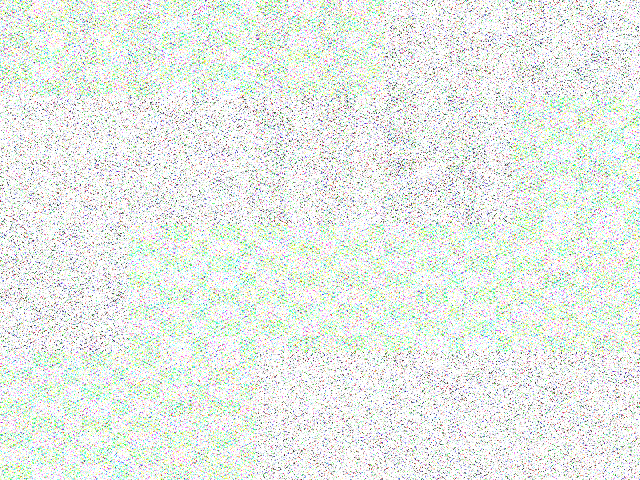

In [50]:
# Define 2 stacks with an original input of 4
wrappers2 = [StackWrapper(2, 4) for i in range(0, 2)]

print(wrappers2[0].stack.stages[0])

%matplotlib notebook
# Let's just have a look at training in a stage-first manner
# Train the upper stages first
for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    
    for wrapper in wrappers2:
        # 0 is the higher stage - I need to change around my terminology!
        wrapper.stack.stages[0].update_cov(data)
        causes = wrapper.stack.stages[0].forward(data)
        pred_inputs = wrapper.stack.stages[0].backward(causes)
        # Compute residuals and clamp at -1, 1
        residuals = (data - pred_inputs)
        clamped_residuals = np.clip(residuals, -1, 1)
        data = clamped_residuals.copy()

for wrapper in wrappers2:
    wrapper.plot_eigenvectors()        

That now works for the upper layer.

[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[ 0]
 [-1]]
---
[[1]]
---
[[0]]
---
[[-1]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[1]]
---
[[0]]
---
[[-1]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[1]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[ 1]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[ 1]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [

[[ 0]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[1]]
---
[[0]]
---
[[-1]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[ 1]
 [-1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]

[[-1]
 [ 0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[ 0]
 [-1]]
---
[[1]]
---
[[0]]
---
[[ 1]
 [-1]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[-1]]
---
[[0]]
---
[[0]
 [1]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[-1]]
---
[[0]]
---
[[0]
 [1]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[1]]
---
[[0]]
---
[[ 1]
 [-1]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[1]]
---
[[0]]
---
[[ 0]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[-1]]
---
[[0]]
---
[[0]
 [1]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[-1]]
---
[[0]]
---
[[0]
 [1]]
---
[[0]
 [0]]
....
[[ 1]
 [-1]]
---
[[1]]
---
[[0]]
---
[[ 0]
 [-1]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]


[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[1]]
---
[[0]]
---
[[-1]
 [-1]]
---
[[0]
 [0]]
....
[[ 0]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[1]]
---
[[0]]
---
[[-1]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [-1]]
---
[[1]]
---
[[0]]
---
[[-1]
 [ 0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[ 0]
 [-1]]
---
[[1]]
---
[[0]]
---
[[-1]
 [-1]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[1]]
---
[[0]]
---
[[-1]
 [-1]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---

[[0]]
---
[[-1]
 [ 0]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[1]]
---
[[0]]
---
[[-1]
 [ 1]]
---
[[0]
 [0]]
....
[[-1]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[ 0]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [0]]
---
[[0]
 [0]]
....
[[ 0]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[1]
 [0]]
---
[[0]
 [0]]
....
[[ 1]
 [-1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[ 1]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [0]]
-

[[-1]
 [ 0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[-1]]
---
[[0]]
---
[[0]
 [1]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[-1]]
---
[[0]]
---
[[0]
 [1]]
---
[[0]
 [0]]
....
[[-1]
 [ 1]]
---
[[-1]]
---
[[0]]
---
[[0]
 [1]]
---
[[0]
 [0]]
....
[[ 1]
 [-1]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[1]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[[0]
 [0]]
....
[[-1]
 [-1]]
---
[[1]]
---
[[0]]
---
[[ 0]
 [-1]]
---
[[0]
 [0]]
....
[[1]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[ 0]
 [-1]]
---
[[1]]
---
[[0]]
---
[[ 0]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [1]]
---
[[-1]]
---
[[0]]
---
[[1]
 [1]]
---
[[0]
 [0]]
....
[[-1]
 [ 0]]
---
[[1]]
---
[[0]]
---
[[ 0]
 [-1]]
---
[[0]
 [0]]
....
[[0]
 [0]]
---
[[0]]
---
[[0]]
---
[[0]
 [0]]
---
[

<IPython.core.display.Javascript object>


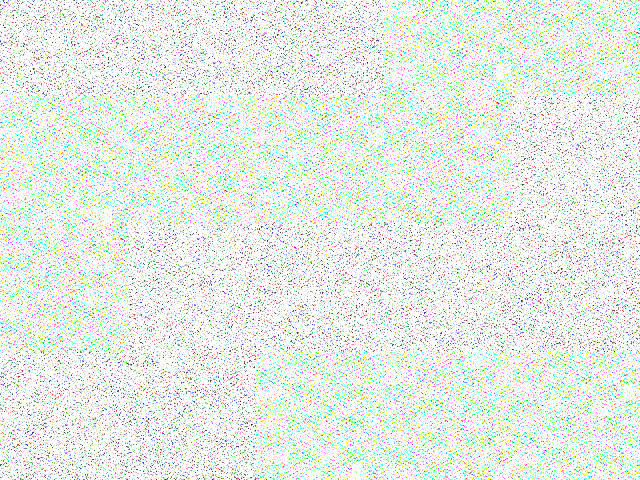

<IPython.core.display.Javascript object>


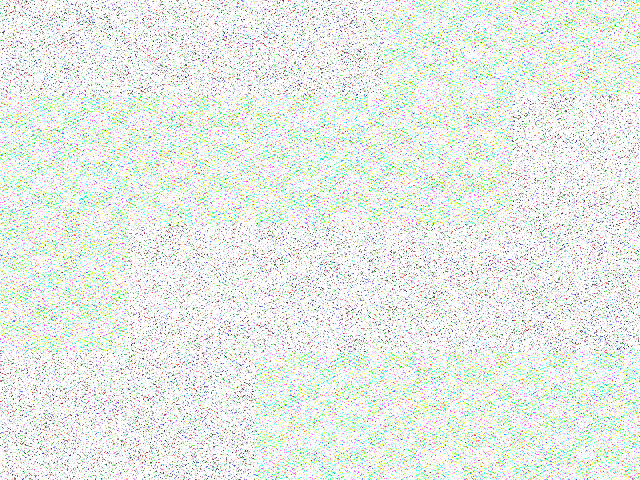

In [61]:
# Now train the lower stages using the output of the upper stages

for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    
    # Pass data through first stage of stack 0
    s1_causes = wrappers2[0].stack.stages[0].forward(data)
    # Use the output to train the second stage of stack 0
    wrappers2[0].stack.stages[1].update_cov(s1_causes)
    # Do a forward and backward pass through the second stage of stack 0
    s_0_causes_0 = wrappers2[0].stack.stages[1].forward(s1_causes)
    pred_inputs_0 = wrappers2[0].stack.stages[1].backward(s_0_causes_0)
    # Compute residuals and clamp at -1, 1
    residuals = (s_0_causes - pred_inputs_0)
    clamped_residuals = np.clip(residuals, -1, 1)
    # Feed residuals to stage 0 of stack 1
    wrappers2[1].stack.stages[1].update_cov(clamped_residuals)
    s_0_causes_1 = wrappers2[1].stack.stages[1].forward(clamped_residuals)
    pred_inputs_1 = wrappers2[1].stack.stages[1].backward(s_0_causes_1)
    print(s1_causes, s_0_causes_0, s_0_causes_1, pred_inputs_0, pred_inputs_1, sep="\n---\n", end="\n....\n")     
        
for wrapper in wrappers2:
    wrapper.plot_eigenvectors()

Ah - that doesn't really work. It kind of gets there. But if we repeat the eigenvectors on the lower stage go.

The lower stage cause is always 0.

It may be better if we use stage wrappers - then we can look at the inputs and outputs of each stage.

In [ ]:
s

Can we combine and do both at the same time?

Ah but what if the training of stack 1 leads to a stage 0 of stack 1 that is the reverse of that trained as part of stack 0. I.e. currently stage 0, stack 0 is [1, 1] and stage 0, stack 1 is [1, -1]. But if we were to train stages 0 using the stack 1 input these may be different?

Stage:Input length: 4Vector length: 2


<IPython.core.display.Javascript object>


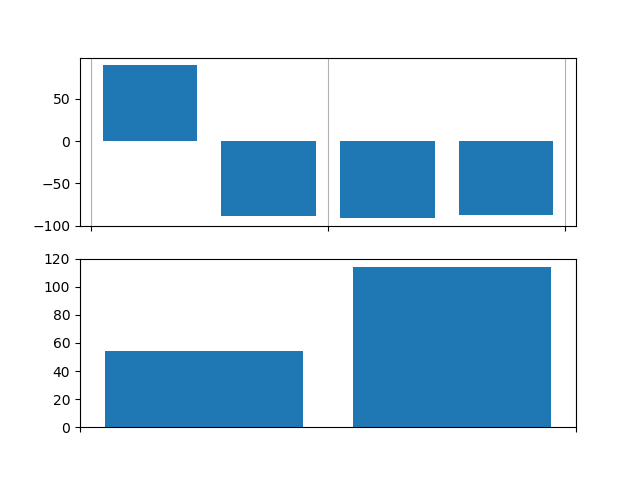

<IPython.core.display.Javascript object>


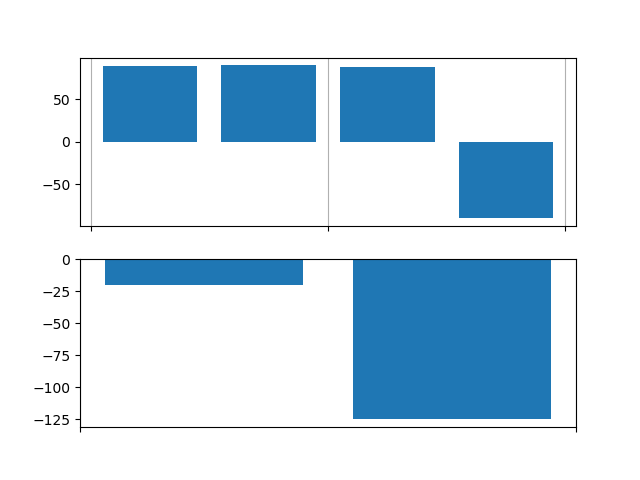

In [45]:
# Define 2 stacks with an original input of 4
wrappers2 = [StackWrapper(2, 4) for i in range(0, 2)]

print(wrappers2[0].stack.stages[0])

%matplotlib notebook
# Let's just have a look at training in a stage-first manner
# Train the upper stages first
for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    
    for wrapper in wrappers2:
        # 0 is the higher stage - I need to change around my terminology!
        wrapper.stack.stages[0].update_cov(data)
        causes = wrapper.stack.stages[0].forward(data)
        pred_inputs = wrapper.stack.stages[0].backward(causes)
        # Compute residuals and clamp at -1, 1
        residuals = (data - pred_inputs)
        clamped_residuals = np.clip(residuals, -1, 1)
        data = clamped_residuals.copy()

for wrapper in wrappers2:
    wrapper.plot_eigenvectors()

Now let's have a look if we train the stages 0 with the causes from stage 1, stack 1 instead of the causes from stage 1, stack 0.

In [ ]:
# Now train the lower stages using the output of the upper stages

for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    
    # Pass data through first stage of stack 0 - get predictions and residuals
    s1_causes = wrappers2[0].stack.stages[0].forward(data)
    preds = wrappers2[0].stack.stages[0].backward(s1_causes)
    # Compute residuals and clamp at -1, 1
    residuals = (s1_causes - preds)
    clamped_residuals = np.clip(residuals, -1, 1)
    # Pass data through first stage of stack 1
    s1_causes = wrappers2[1].stack.stages[0].forward(clamped_residuals)
    # Repeat as above but switch around the stacks
    # Use the output to train the second stage of stack 0
    wrappers2[1].stack.stages[1].update_cov(s1_causes)
    # Do a forward and backward pass through the second stage of stack 0
    s_0_causes = wrappers2[1].stack.stages[1].forward(s1_causes)
    pred_inputs_0 = wrappers2[1].stack.stages[1].backward(s_0_causes)
    # Compute residuals and clamp at -1, 1
    residuals = (s_0_causes - pred_inputs_0)
    clamped_residuals = np.clip(residuals, -1, 1)
    # Feed residuals to stage 0 of stack 1
    wrappers2[0].stack.stages[1].update_cov(clamped_residuals)
    s_0_causes = wrappers2[1].stack.stages[1].forward(clamped_residuals)
    pred_inputs_1 = wrappers2[1].stack.stages[1].backward(s_0_causes)
    # print(s1_causes, pred_inputs_0, pred_inputs_1, sep="\n---\n")     
        
for wrapper in wrappers2:
    wrapper.plot_eigenvectors()

In [ ]:
# Define 2 stacks with an original input of 4
wrappers2 = [StackWrapper(2, 4) for i in range(0, 2)]

print(wrappers2[0].stack.stages[0])

%matplotlib notebook
# Let's just have a look at training in a stage-first manner
# Train the upper stages first
for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    
    for wrapper in wrappers2:
        # 0 is the higher stage - I need to change around my terminology!
        
        causes = wrapper.stack.stages[0].forward(data)
        pred_inputs = wrapper.stack.stages[0].backward(causes)
        # Compute residuals and clamp at -1, 1
        residuals = (data - pred_inputs)
        clamped_residuals = np.clip(residuals, -1, 1)
        data = clamped_residuals.copy()
    # Update covariance of first stage of stack 0  
    wrappers2[0].stack.stages[0].update_cov(data)
    # Pass data through first stage of stack 0
    s1_causes = wrappers2[0].stack.stages[0].forward(data)
    # Use the output to train the second stage of stack 0
    wrappers2[0].stack.stages[1].update_cov(s1_causes)
    # Do a forward and backward pass through the second stage of stack 0
    s_0_causes = wrappers2[0].stack.stages[1].forward(s1_causes)
    pred_inputs_0 = wrappers2[0].stack.stages[1].backward(s_0_causes)
    # Compute residuals and clamp at -1, 1
    residuals = (s_0_causes - pred_inputs_0)
    clamped_residuals = np.clip(residuals, -1, 1)
    # Feed residuals to stage 0 of stack 1
    wrappers2[0].stack.stages[1].update_cov(clamped_residuals)
    s_0_causes = wrappers2[1].stack.stages[1].forward(clamped_residuals)
    pred_inputs_1 = wrappers2[1].stack.stages[1].backward(s_0_causes)
    # print(s1_causes, pred_inputs_0, pred_inputs_1, sep="\n---\n")
    # Combine predicted inputs and pass back
    pred_causes = np.clip(pred_inputs_0 + pred_inputs_1, -1, 1)
    pred_inputs =  wrappers2[0].stack.stages[0].backward(pred_causes)
    # Then pass predicted outputs to train

for wrapper in wrappers2:
    wrapper.plot_eigenvectors()  

With random mixed in data this does not converge...Also the eigenvectors are out (e.g. [79, 99], [-87, 92]).

There seems to be something wrong here - an input of [-1, -1] and an eigenvector of [-91 -88] doesn't lead to an r of 1. We need .copy() when we do the equating.

In [ ]:
wrappers[1].vpu.backward(1)

In [ ]:
wrappers[1].vpu.forward(-1*np.ones(shape=(2,1)))

In [ ]:
wrappers[1].input_buffer[:, -1]

In [ ]:
wrappers[1].r_buffer[:, -1]

In [ ]:
wrappers[1].iterate(-1*np.ones(shape=(2,1)))

In [ ]:
for w in wrappers:
    print(w.vpu.eigenvector)

## Create Two Stacks

Now we create and train two stacks.

First we can train stack 0, stage 0 as this just needs X on the forward pass.

In [96]:
# Stack 0, stage 1 - vector length 2, input length 4
s0s1 = StageWrapper(4, 2)
# Stack 1, stage 1 - vector length 2, input length 4
s1s1 = StageWrapper(4, 2)
# Stack 0, stage 0 - vector length 2, input length 2
s0s0 = StageWrapper(2, 2)
# Stack 1, stage 0 - vector length 2, input length 2
s1s0 = StageWrapper(2, 2)

for _ in range(0, 1000):
    data = rand_opposite(size=size*2, negative=True)
    
    # Pass data to s0 s1 first
    causes, pred_inputs, clamped_residuals = s0s1.iterate(data)
    # Use the output to train the second stage of stack 0
    causes, pred_inputs, clamped_residuals = s0s0.iterate(causes)
    # Feed residuals to stage 0 of stack 1
    causes, pred_inputs, clamped_residuals = s1s0.iterate(clamped_residuals)

In [97]:
print(s0s1.stage.get_eigenvectors())
print(s0s0.stage.get_eigenvectors())
print(s1s0.stage.get_eigenvectors())

[array([[ 89],
       [-90]], dtype=int8), array([[ 89],
       [-90]], dtype=int8)]
[array([[-127],
       [   0]], dtype=int8)]
[array([[ -45],
       [-118]], dtype=int8)]


Stage 0 eigenvectors are unstable - they change with every training. But the first stage eigenvectors are stable.

In [98]:
ev_s0s0 = s0s0.stage.get_eigenvectors()[0]
ev_s1s0 = s0s0.stage.get_eigenvectors()[0]
np.dot(ev_s0s0.T, ev_s1s0)

array([[1]], dtype=int8)

<IPython.core.display.Javascript object>


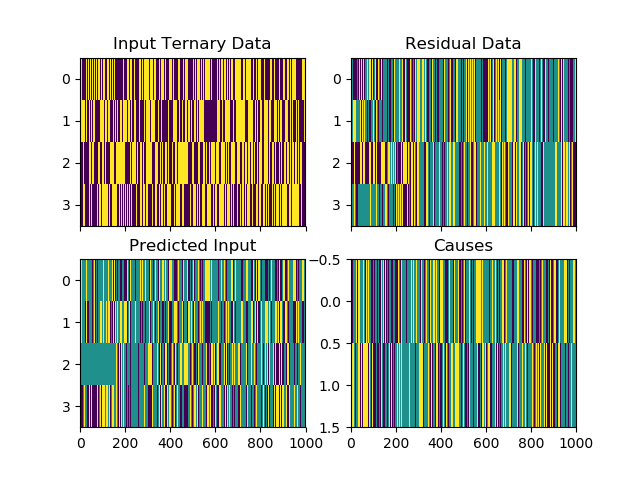

In [99]:
s0s1.plot_buffers()

<IPython.core.display.Javascript object>


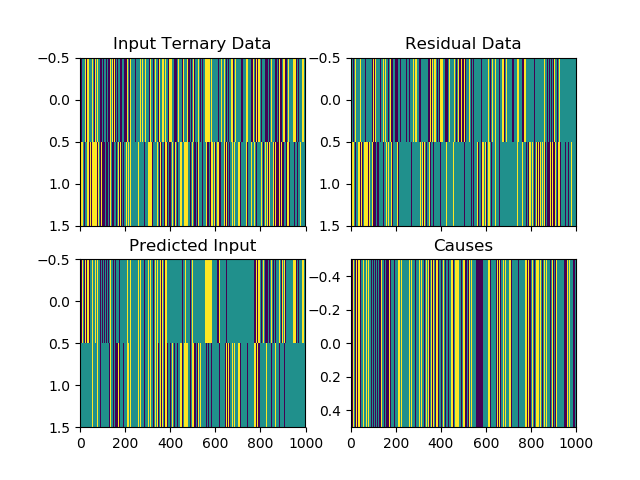

In [100]:
s0s0.plot_buffers()

In [101]:
s0s0.input_buffer.mean(axis=1)

array([-0.033, -0.002])

In [102]:
s1s0.input_buffer.mean(axis=1)

array([-0.008, -0.005])

Let's see whether the predictions of the two stage 0s sum to the causes from stack 0, stage 1.

In [103]:
predicted_causes = s0s0.pred_buffer + s1s0.pred_buffer

In [105]:
predicted_causes

array([[ 1.,  1., -1., ...,  0., -2.,  0.],
       [-1., -1.,  0., ...,  0., -1., -1.]])

In [109]:
error = s0s1.r_buffer - predicted_causes

In [110]:
error.mean(axis=1)

array([-0.014,  0.008])

In [112]:
error.sum(axis=1)

array([-14.,   8.])

Yes - so the components are approximately summing to the input from the stage above and are still approximately orthogonal.

But they change because there is no pattern to the data at the stage 0 level. Would this be the case

So the mean is still roughly zero. We've seen from the scale space experiments that the residuals are centred around 0, so have a zero mean.

Is it because the input to stage 0 is roughly random?

Let's see with random data.

In [94]:
# Stack 0, stage 1 - vector length 2, input length 4
s0s1 = StageWrapper(4, 2)
# Stack 1, stage 1 - vector length 2, input length 4
s1s1 = StageWrapper(4, 2)
# Stack 0, stage 0 - vector length 2, input length 2
s0s0 = StageWrapper(2, 2)
# Stack 1, stage 0 - vector length 2, input length 2
s1s0 = StageWrapper(2, 2)

for _ in range(0, 1000):
    data = np.random.randint(low=-1, high=2, size=(4, 1), dtype=np.int8)
    
    # Pass data to s0 s1 first
    causes, pred_inputs, clamped_residuals = s0s1.iterate(data)
    # Use the output to train the second stage of stack 0
    causes, pred_inputs, clamped_residuals = s0s0.iterate(causes)
    # Feed residuals to stage 0 of stack 1
    causes, pred_inputs, clamped_residuals = s1s0.iterate(clamped_residuals)

print(s0s1.stage.get_eigenvectors(), "\n----\n")
print(s0s0.stage.get_eigenvectors(), "\n----\n")
print(s1s0.stage.get_eigenvectors(), "\n----\n")

[array([[-126],
       [  10]], dtype=int8), array([[-124],
       [ -26]], dtype=int8)] 
----

[array([[109],
       [ 64]], dtype=int8)] 
----

[array([[ -59],
       [-112]], dtype=int8)] 
----



Yes - if the data is random, with no pattern, our eigenvectors change with each iteration.

Are the stage 0 eigenvectors still orthogonal?

In [95]:
ev_s0s0 = s0s0.stage.get_eigenvectors()[0]
ev_s1s0 = s0s0.stage.get_eigenvectors()[0]
np.dot(ev_s0s0.T, ev_s1s0)

array([[105]], dtype=int8)

Roughly orthogonal.

What if we try layerwise training